In [1]:
from decouple import config
from mvpa_functions import load_pickle, ados
import nilearn.plotting as nplot
import os
import re
from nilearn.reporting import get_clusters_table
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

## Read in model and test images

In [7]:
path_to_models = os.path.join(config('ml'), 'pickle', 'test_train_cv_10')
test_parameters = ados('G2' , mean_images=True, test_train='test').reset_index(drop=True)
train_parameters = ados('G2', mean_images=True, test_train='train')
ml_models = dict(zip([re.sub('.pickle', '', key) for key in os.listdir(path_to_models)], 
                     [load_pickle(re.sub('\.pickle', '', os.path.join(path_to_models, pickle))) for pickle in os.listdir(path_to_models)]))

## Plot weights

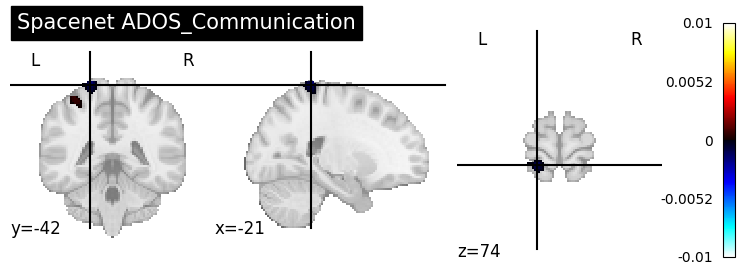

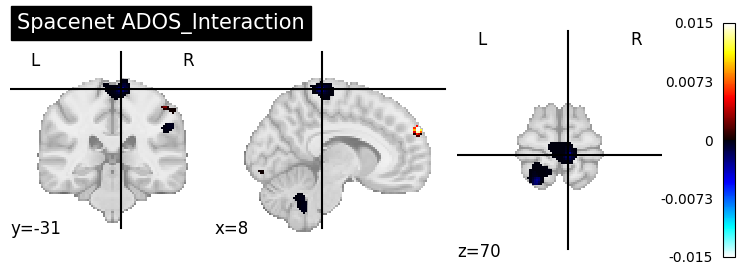

In [8]:
for domain in ml_models:
    nplot.plot_stat_map(
        ml_models[domain].coef_img_,
        title=f"Spacenet {domain}",
        #threshold='auto'
    )

## Calculate performance metrics

In [9]:
%%capture
test_stats =  dict(zip([key for key in ml_models.keys()], [{} for key in ml_models.keys()]))

for model in test_stats.keys():
    test_stats[model]['y_pred'] = ml_models[model].predict(test_parameters['paths']).ravel()
    test_stats[model]['r2'] = ml_models[model].score(test_parameters['paths'], test_parameters[model])
    test_stats[model]['mse'] = np.mean(np.abs(test_parameters[model] - test_stats[model]['y_pred']))

In [10]:
ml_models['ADOS_Communication'].get_params()

{'alphas': None,
 'cv': 10,
 'debias': False,
 'eps': 0.1,
 'fit_intercept': True,
 'high_pass': None,
 'l1_ratios': 0.5,
 'low_pass': None,
 'mask': None,
 'max_iter': 200,
 'memory': Memory(location=None),
 'memory_level': 1,
 'n_alphas': 10,
 'n_jobs': 8,
 'penalty': 'tv-l1',
 'screening_percentile': 20.0,
 'standardize': True,
 't_r': None,
 'target_affine': None,
 'target_shape': None,
 'tol': 0.0001,
 'verbose': 1}

In [11]:
for model in test_stats.keys():
    print(f"Mean square error for {model}: {test_stats[model]['mse']}")
    print(f"R2 for {model}: {test_stats[model]['r2']}")

Mean square error for ADOS_Communication: 1.5175723982080447
R2 for ADOS_Communication: -0.09106536267906051
Mean square error for ADOS_Interaction: 1.0938423565675968
R2 for ADOS_Interaction: -3.8070380560600423


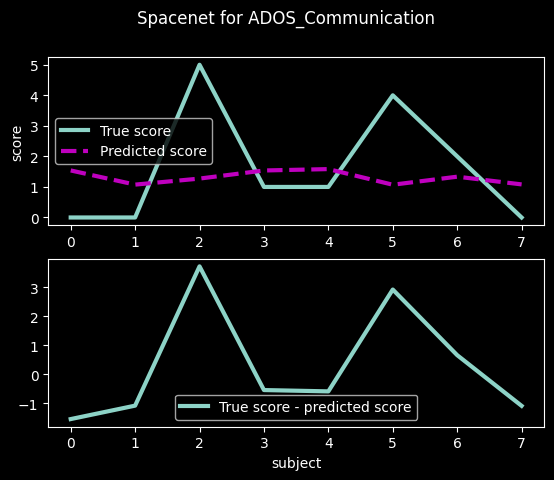

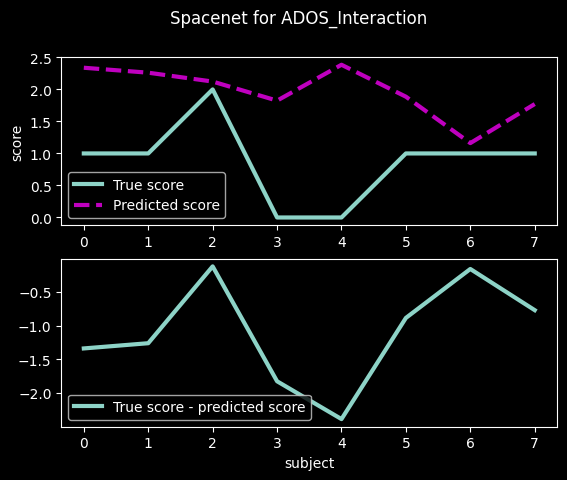

In [12]:
for model in test_stats.keys():
    plt.figure()
    plt.suptitle(f"Spacenet for {model} ")
    ax1 = plt.subplot(211)
    ax1.plot(test_parameters[model], label="True score", linewidth=3)
    ax1.plot(test_stats[model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax1.set_ylabel("score")
    plt.legend(loc="best")
    ax2 = plt.subplot(212)
    ax2.plot(
        test_parameters[model] - test_stats[model]['y_pred'], label="True score - predicted score", linewidth=3
    )
    ax2.set_xlabel("subject")
    plt.legend(loc="best")